# Task 4

Sequence-to-vector prediction of voltage recordings and ECG Signals to perform activation map reconstruction 
(i.e. transform 12x500 standard leads recordings to a 75x1 activation map using a neural network)

Download the dataset from the Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals using the script: https://library.ucsd.edu/dc/object/bb29449106

The dataset Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals consists of pairs of computationally simulated intracardiac transmembrane voltage recordings and ECG signals. In total, 16140 organ-level simulations were conducted to create this dataset. Simulations were performed using Lassen supercomputer at Lawrence Livermore National Lab (LLNL), concurrently utilizing 4 GPUs and 40 CPU cores. Each simulation produced pairs of 500ms-by-10 raw electrode signals and 500ms-by-75 transmembrane voltage signals. For convenience, we collect those signals in matrices and give them the following names:

Tensor	Description	  Shape	          Notes
X 	Row electrode signals	 10×500 	10-lead ECG signals from the simulated torso (in Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals)
V 	Activation map	 75×500 	Transmembrane voltage signals from the simulated heart (in Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals)
E 	12-lead ECG signals	 12×500 	12-lead ECG signals obtained by get_standard_leads( X )
A 	Activation map	 75×1 	Activation time, defined as  Ai=minj(Vij) 
IMPORTANT : The raw data in the dataset consists of 10-lead ECG signals and 75-lead transmembrane voltage signals. The 12-lead ECG signals are obtained from the 10-lead ECG signals using the function get_standard_leads (in the file cardiac_ml_tools.py).

The overall generation process is shown in the following image. The ECG signal is recorded using 10 virtual electrodes and the transmembrane voltages are recorded at 75 points within the myocardium. The transmembrane voltages are then used to generate the spatio-temporal activation maps.

In [14]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
%%shell
#!/bin/bash

# Download all the components of the dataset from https://library.ucsd.edu/dc/object/bb29449106
# and put them in the directory intracardiac_dataset

# Make the directory
echo "Making directory intracardiac_dataset"
mkdir -p intracardiac_dataset
echo "Done"

# Move into the directory
cd intracardiac_dataset

# Download the first element (README.md)
echo "Downloading the dataset - This may take a while"
wget https://library.ucsd.edu/dc/object/bb29449106/_1_1.md/download -O README.md
for i in {2..22}
do
    wget https://library.ucsd.edu/dc/object/bb29449106/_${i}_1.tgz/download
    echo "Unzipping the file"
    tar -xvzf download
    rm -f download
done
echo "Done"

# Return to the parent directory
cd -

In [4]:
# %run cardiac_ml_tools.py
# cardiac_ml_tools.py (download_intracardiac_dataset.sh)

# file containing functions for cardiac ml
import glob, re, os
from typing import List
import numpy as np

# %%
# funtion to read the data
def read_data_dirs(
        dirs_names : List[str] = ['../intracardiac_dataset/data_hearts_dd_0p2/'],
        verbose : int = 0) -> List[List[str]]:
    """
    Read the numpy files in the given directories.
    Returns a list of file pairs ECG/Vm.
    
    Parameters
    ----------
    dirs_names : List[str]
        List of directories containing the data.
    verbose : int
        Verbosity level.
    
    Returns
    -------
    file_pairs : List[List[str]]
        List of file pairs.
    """
    file_pairs = []
    
    for dir in dirs_names:    
        all_files = sorted(glob.glob(dir + '/*.npy'))
        files_Vm=[]
        files_pECG=[]
        
        if verbose > 0:
            print('Reading files...',end='')
        for file in all_files:
            if 'VmData' in file:
                files_Vm.append(file)
            if 'pECGData' in file:
                files_pECG.append(file)
        if verbose > 0:        
            print(' done.')
        
        if verbose > 0:
            print('len(files_pECG) : {}'.format(len(files_pECG)))
            print('len(files_Vm) : {}'.format(len(files_Vm)))
        
        for i in range(len(files_pECG)):  
            VmName =  files_Vm[i]
            VmName = VmName.replace('VmData', '')
            pECGName =  files_pECG[i]
            pECGName = pECGName.replace('pECGData', '')            
            if pECGName == VmName :
                file_pairs.append([files_pECG[i], files_Vm[i]])
            else:
                print('Automatic sorted not matching, looking for pairs ...',end='')
                for j in range(len(files_Vm)):
                    VmName =  files_Vm[j]
                    VmName = VmName.replace('VmData', '')
                    if pECGName == VmName :
                        file_pairs.append([files_pECG[i], files_Vm[j]])
                print('done.')       
    return file_pairs


# function to transform the data
def get_standard_leads(
        pECGnumpy : np.ndarray
    ) -> np.ndarray :
    """
    Get the standard 12-lead from the 10-lead ECG.
    
    Parameters
    ----------
    pECGnumpy : np.ndarray
        10-lead ECG.
        
    Returns
    -------
    ecg12aux : np.ndarray
        12-lead ECG.
    """
    # pECGnumpy  : RA LA LL RL V1 V2 V3 V4 V5 V6
    # ecg12aux : i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5, v6
    ecg12aux = np.zeros((pECGnumpy.shape[0],12))
    WilsonLead = 0.33333333 * (pECGnumpy[:,0] + pECGnumpy[:,1] + pECGnumpy[:,2])
    # Lead I: LA - RA
    ecg12aux[:,0] = pECGnumpy[:,1] - pECGnumpy[:,0]
    # Lead II: LL - RA
    ecg12aux[:,1] = pECGnumpy[:,2] - pECGnumpy[:,0]
    # Lead III: LL - LA
    ecg12aux[:,2] = pECGnumpy[:,2] - pECGnumpy[:,1]
    # Lead aVR: 3/2 (RA - Vw)
    ecg12aux[:,3] = 1.5*(pECGnumpy[:,0] - WilsonLead)
    # Lead aVL: 3/2 (LA - Vw)
    ecg12aux[:,4] = 1.5*(pECGnumpy[:,1] - WilsonLead)
    # Lead aVF: 3/2 (LL - Vw)
    ecg12aux[:,5] = 1.5*(pECGnumpy[:,2] - WilsonLead)
    # Lead V1: V1 - Vw
    ecg12aux[:,6] = pECGnumpy[:,4] - WilsonLead
    # Lead V2: V2 - Vw
    ecg12aux[:,7] = pECGnumpy[:,5] - WilsonLead
    # Lead V3: V3 - Vw
    ecg12aux[:,8] = pECGnumpy[:,6] - WilsonLead
    # Lead V4: V4 - Vw
    ecg12aux[:,9] = pECGnumpy[:,7] - WilsonLead
    # Lead V5: V5 - Vw
    ecg12aux[:,10] = pECGnumpy[:,8] - WilsonLead
    # Lead V6: V6 - Vw
    ecg12aux[:,11] = pECGnumpy[:,9] - WilsonLead

    return ecg12aux

# funtion to get the activation time
def get_activation_time(
        Vm : np.ndarray
    ) -> np.ndarray :
    """
    Get the activation time from the Vm.
    
    Parameters
    ----------
    Vm : np.ndarray
        Vm.
        
    Returns
    -------
    actTime : np.ndarray
        Activation time.
    """
    actTime = []
    # check that Vm has 75 columns
    if Vm.shape[1] != 75:
        print('Error: Vm does not have 75 columns')
        return actTime
    for col in range(0,75,1):
        actTime.append(np.argmax(Vm[:,col]>0))
    actTime = np.asarray(actTime)
    actTime = np.reshape(actTime,(75,1))
    return actTime

In [7]:
# %% Reading file pairs  
data_dirs = []
regex = r'data_hearts_dd_0p2*'
#DIR='../content/intracardiac_dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
DIR='C:/Users/Justin/Documents/LLNL/Data/Task3/dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh

for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))

print(len(data_dirs))

Number of file pairs: 16117
Example of file pair:
C:/Users/Justin/Documents/LLNL/Data/Task3/dataset/data_hearts_dd_0p2\pECGData_hearts_dd_0p2_volunteer.v10_pattern.0.npy
C:/Users/Justin/Documents/LLNL/Data/Task3/dataset/data_hearts_dd_0p2\VmData_hearts_dd_0p2_volunteer.v10_pattern.0.npy
17


Case 213 : C:/Users/Justin/Documents/LLNL/Data/Task3/dataset/data_hearts_dd_0p2\pECGData_hearts_dd_0p2_volunteer.v1_pattern.18.npy


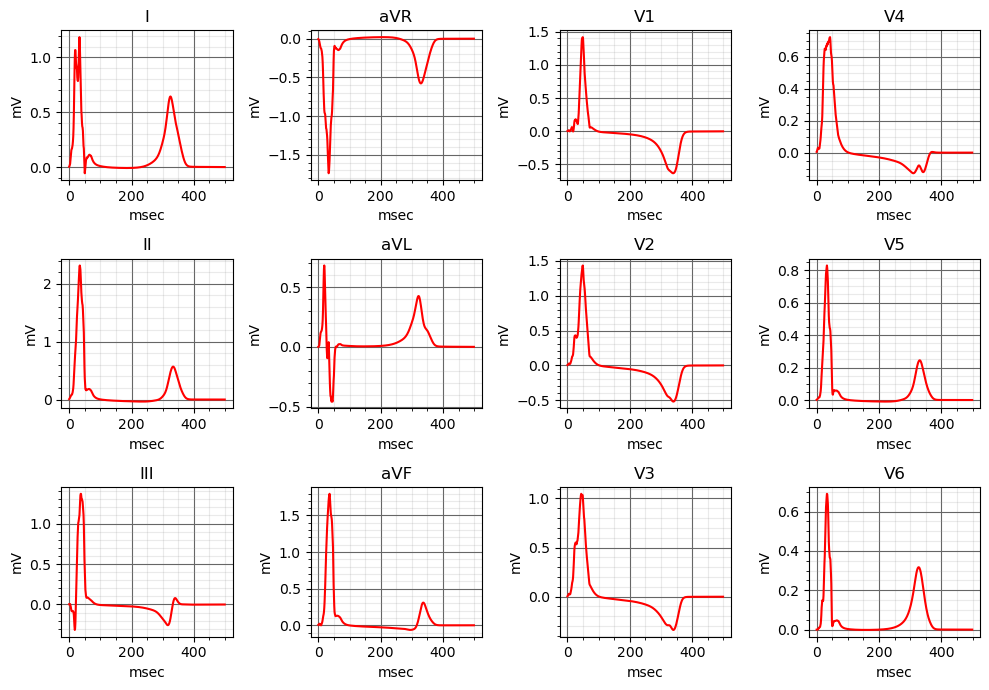

In [8]:
# %% Example of file pair
case = 213
# ECG plot
row = 3
column = 4
num_timesteps = 500
plt.figure(figsize=(10, 7))
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {1:1,2:5,3:9,4:2,5:6,6:10,7:3,8:7,9:11,10:4,11:8,12:12} # reorder the leads to standard 12-lead ECG display

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

# create a figure with 12 subplots
for i in range(pECGData.shape[1]):
    plt.subplot(row, column, reorder[i + 1])
    plt.plot(pECGData[0:num_timesteps,i],'r')
    plt.title(titles[i])
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()


Case 213 : C:/Users/Justin/Documents/LLNL/Data/Task3/dataset/data_hearts_dd_0p2\pECGData_hearts_dd_0p2_volunteer.v1_pattern.18.npy


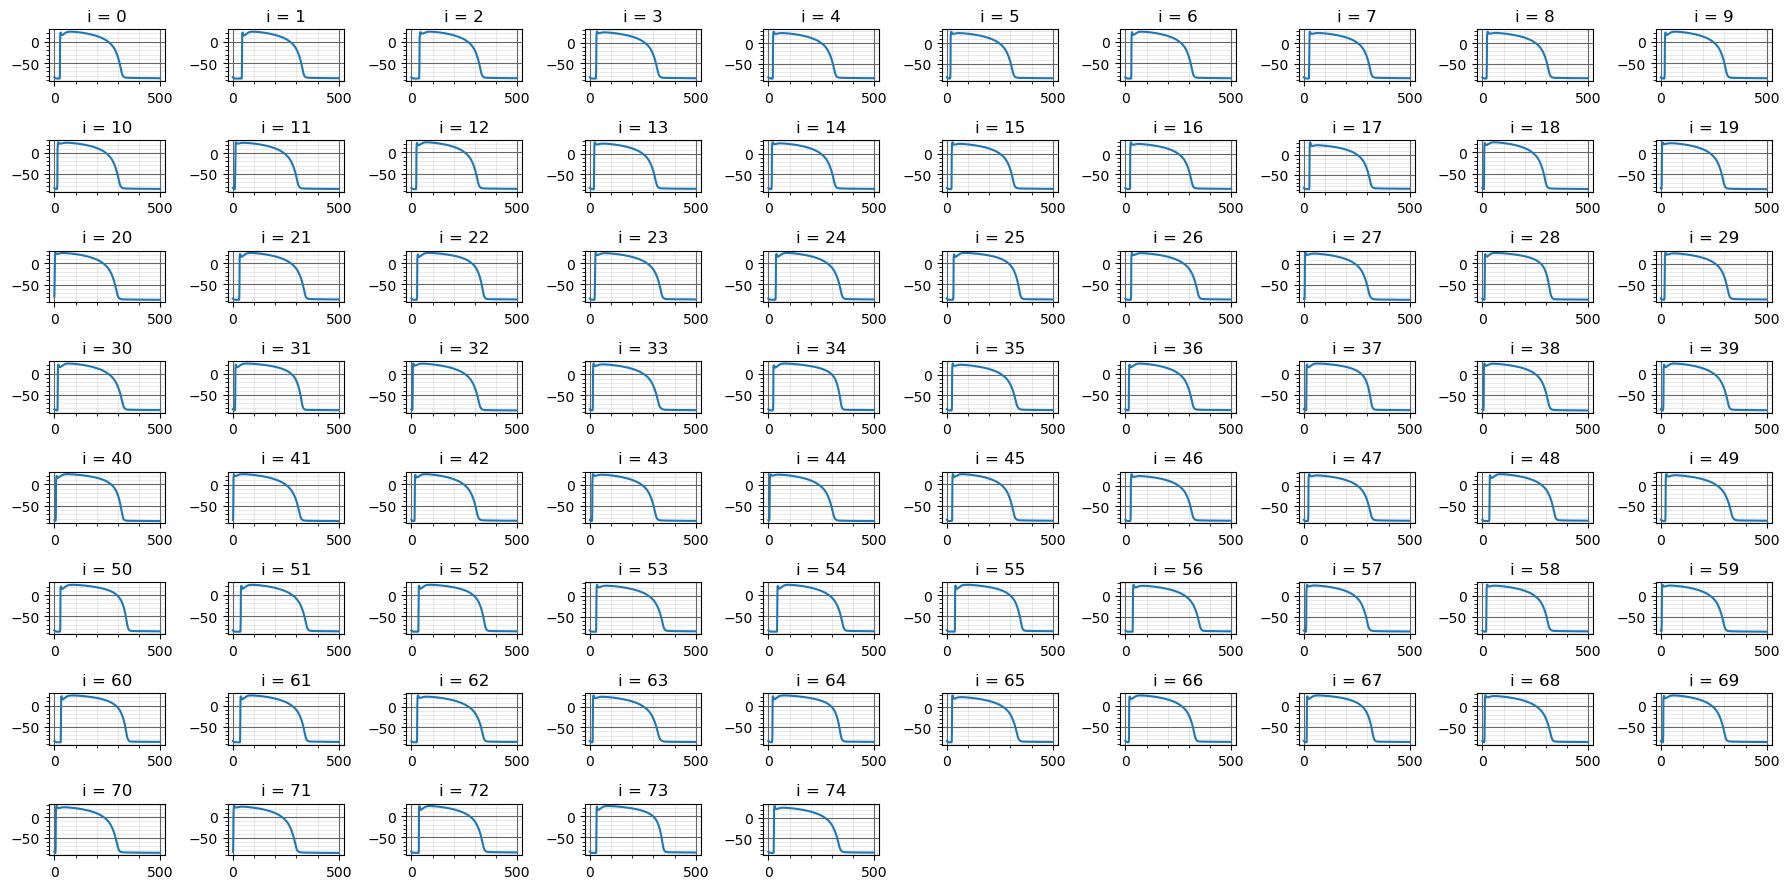

In [9]:
# %%# Example of file pair
case = 213
# Vm plot
row = 7
column = 10
plt.figure(figsize=(18, 9))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

for count, i in enumerate(range(VmData.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmData[0:num_timesteps,i])
    plt.title(f'i = {i}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

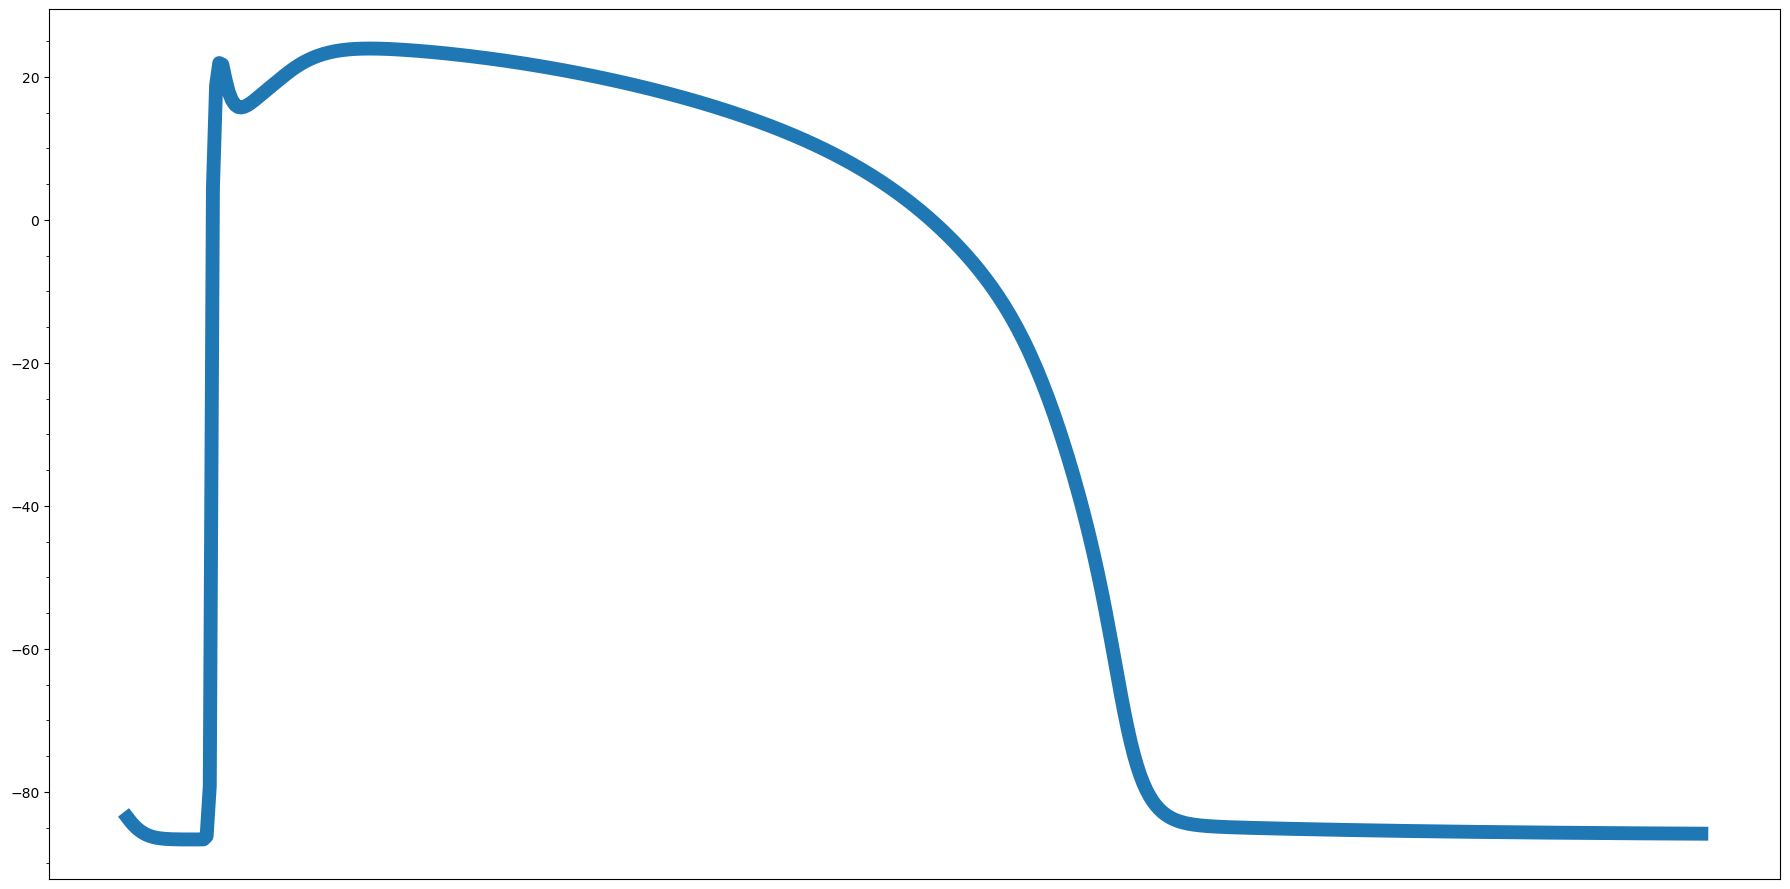

In [10]:
# %% Plotting 1 activation plot 
case = 213
# Vm plot
plt.figure(figsize=(18, 9))
VmData = np.load(file_pairs[case][1])
count = 0
i = 0
plt.plot(VmData[0:num_timesteps,i], linewidth=10)
#plt.title(f'i = {i}')
#plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
#plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.rcParams['axes.linewidth'] = 12
plt.xticks([])
#plt.yticks([])

plt.tight_layout()
plt.show()
# close
plt.close()

Case 213 : C:/Users/Justin/Documents/LLNL/Data/Task3/dataset/data_hearts_dd_0p2\pECGData_hearts_dd_0p2_volunteer.v1_pattern.18.npy
Case 213 : C:/Users/Justin/Documents/LLNL/Data/Task3/dataset/data_hearts_dd_0p2\pECGData_hearts_dd_0p2_volunteer.v1_pattern.18.npy


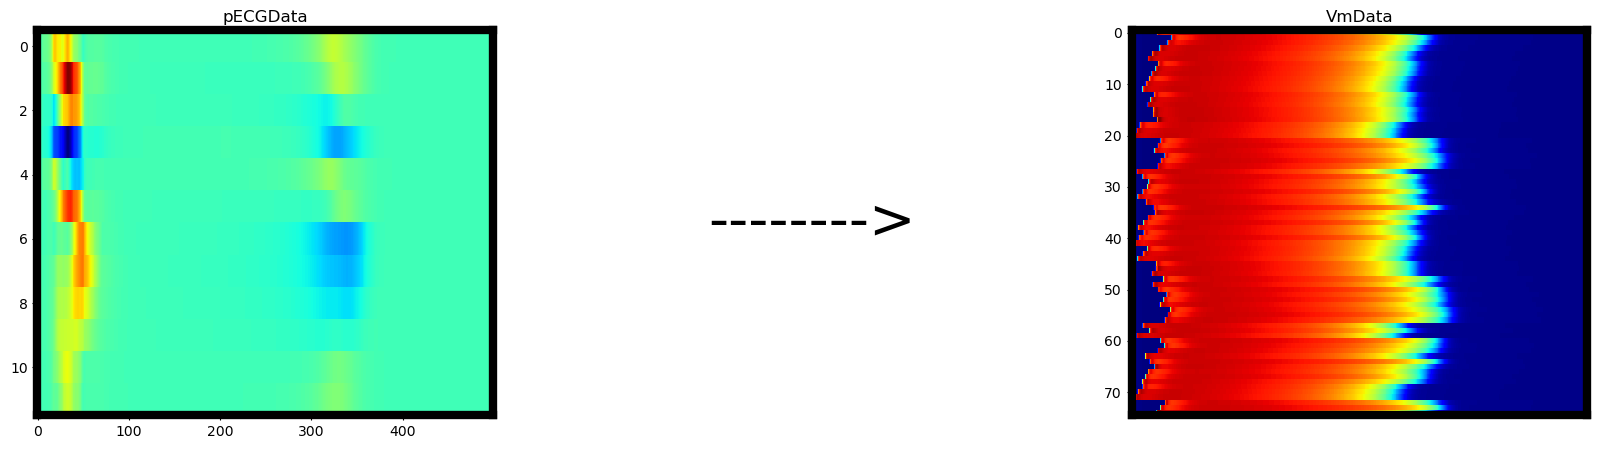

In [36]:
# %% make a plot with the "pECGData" -> "ActTime"
case = 213

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 3
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print a text "->"
plt.text(0.5, 0.5, '-------->', fontsize=40, horizontalalignment='center', verticalalignment='center')
plt.axis('off')
plt.subplot(row, column, 3)
# plot Vm transposed
plt.imshow(VmData.T, cmap='jet', interpolation='nearest', aspect='auto')
# not xticks
plt.xticks([])
plt.title('VmData')
plt.rcParams['axes.linewidth'] = 6

plt.show()
plt.close()

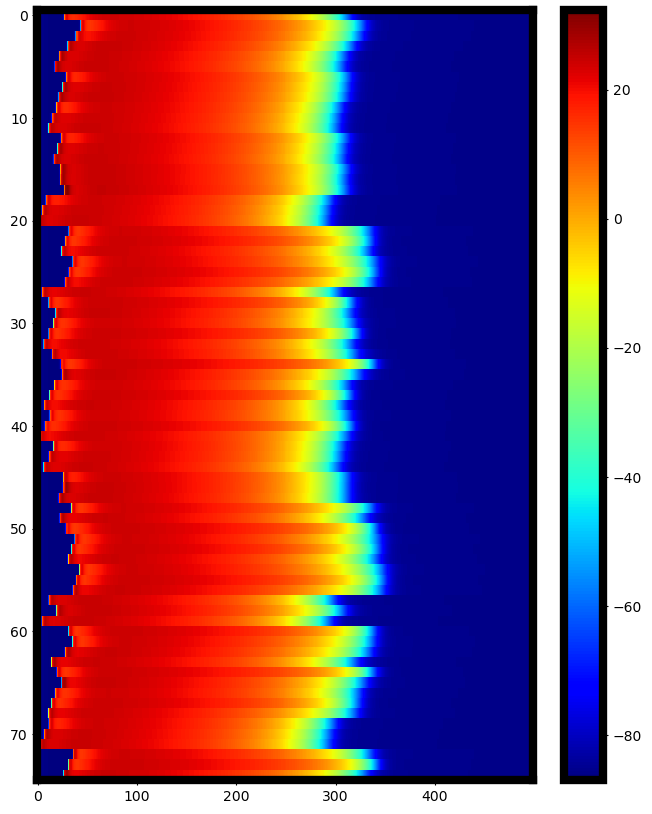

In [37]:
# %% Plot only VmData over all leads, heatmap 
# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 3
plt.figure(figsize=(8, 10))
# plot pECGData transposed
# plot Vm transposed
plt.imshow(VmData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.colorbar()
# not xticks
#plt.xticks([])
#plt.yticks([])
plt.rcParams['axes.linewidth'] = 12


#plt.title('VmData')
#ax.set_xlim([0 500])
plt.show()
plt.close()

In [15]:
# Goal: pECGData to VmData

'''
How to extract value from a case
case = 213

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])
'''

print("VmData: ", VmData.shape)
print("pECGData: ", pECGData.shape)

VmData:  (500, 75)
pECGData:  (500, 12)


In [16]:
# concat the data into one place

# To choose which cases should be for testing and which should be for training
num_of_peps = 5000 #len(file_pairs)
Data_points = np.linspace(0, num_of_peps - 1, num = num_of_peps, dtype = int)
train_indx, test_indx = train_test_split(Data_points, test_size=0.2, random_state=43)

vmdata = []
standard_leads = []
Y = []
for case in range(num_of_peps):
    pECGData = np.load(file_pairs[case][0])
    pECGData = get_standard_leads(pECGData)
    standard_leads.append(pECGData.T)
    VmData = np.load(file_pairs[case][1])
    vmdata.append(VmData)

    y = get_activation_time(VmData)
    Y.append(y)

vmdata = torch.tensor(np.array(vmdata))
standard_leads = torch.tensor(np.array(standard_leads))
ActTime = np.array(Y)

# get the data
y_train = vmdata[train_indx,:,:]
y_test = vmdata[test_indx,:,:]
X_train = standard_leads[train_indx,:,:]
X_test = standard_leads[test_indx,:,:]

In [17]:
# normalize tensors
# Find the minimum and maximum values across the tensors
min_value = torch.min(torch.min(y_train), torch.min(y_test))
max_value = torch.max(torch.max(y_train), torch.max(y_test))

# Convert the tensors to Python scalars
min_value = min_value.item()
max_value = max_value.item()

normalized_y_train = (y_train - min_value) / (max_value-min_value)  # (tensor - min) / range

normalized_y_test = (y_test - min_value) / (max_value-min_value)

## print shapes
print("train shape: ", X_train.shape, normalized_y_train.shape)
print("test shape: ", X_test.shape, normalized_y_test.shape)

train shape:  torch.Size([4000, 12, 500]) torch.Size([4000, 500, 75])
test shape:  torch.Size([1000, 12, 500]) torch.Size([1000, 500, 75])


In [18]:
## Create dataloader
train_dataset = TensorDataset(X_train, normalized_y_train.permute(0,2,1))
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

data_iter = iter(train_dataloader) # create iterator of dataloader to check if data is ok
first_batch = next(data_iter)

data_shape = first_batch[0].shape
labels_shape = first_batch[1].shape

print("Data shape:", data_shape)
print("Labels shape:", labels_shape)

Data shape: torch.Size([32, 12, 500])
Labels shape: torch.Size([32, 75, 500])


In [19]:
## network

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=64, kernel_size=25, padding = 12)
        self.bn1 = nn.BatchNorm1d(64)  # Batch Normalization after conv1
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=15, padding = 7)
        self.bn2 = nn.BatchNorm1d(128)  # Batch Normalization after conv2
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=9, padding = 4)
        self.bn3 = nn.BatchNorm1d(256)  # Batch Normalization after conv3
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding = 1)
        self.bn4 = nn.BatchNorm1d(512)  # Batch Normalization after conv4

        self.conv5 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, padding = 1)
        self.bn5 = nn.BatchNorm1d(1024)  # Batch Normalization after conv4
        self.conv6 = nn.Conv1d(in_channels=1024, out_channels=75, kernel_size=3, padding = 1)


        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)

        x = self.conv6(x)
        x = self.sigmoid(x)

        return x

In [27]:
# Device check and Methods

#device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Check for GPU availability and set device
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    device = torch.device("cuda")
    current_device_idx = torch.cuda.current_device()
else:
    device_count = 0
    device = torch.device("cpu")
    current_device_idx = None

# Print device information
print(f"Number of available GPUs: {device_count}")
print(f"Current device index: {current_device_idx}")
if device == torch.device("cuda"):
    print(f"Current device name: {torch.cuda.get_device_name(current_device_idx)}")
else:
    print("Current device name: CPU")


Using GPU
Number of available GPUs: 1
Current device index: 0
Current device name: NVIDIA GeForce GTX 1660 Ti


In [28]:
# create model
model = Network().to(device)
num_epochs = 100

criterion = nn.MSELoss()

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters:", num_params)

Number of parameters: 2639499


In [29]:
### training loop

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

model.train()
for epoch in range(num_epochs):
    for batch_data, batch_labels in train_dataloader:
        # Move data and labels to GPU if available
        if torch.cuda.is_available():
            batch_data = batch_data.cuda()
            batch_labels = batch_labels.cuda()
        batch_labels = batch_labels.squeeze(1)
        # Forward pass
        batch_data = batch_data.float()
        batch_labels = batch_labels.float()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/100, Loss: 0.013238365761935711
Epoch 2/100, Loss: 0.016701702028512955
Epoch 3/100, Loss: 0.012065945193171501
Epoch 4/100, Loss: 0.010613624006509781
Epoch 5/100, Loss: 0.009547838941216469
Epoch 6/100, Loss: 0.009905311278998852
Epoch 7/100, Loss: 0.00925097893923521
Epoch 8/100, Loss: 0.008404042571783066
Epoch 9/100, Loss: 0.0076693822629749775
Epoch 10/100, Loss: 0.006901201792061329
Epoch 11/100, Loss: 0.007681770715862513
Epoch 12/100, Loss: 0.006628829520195723
Epoch 13/100, Loss: 0.006776322610676289
Epoch 14/100, Loss: 0.00854145921766758
Epoch 15/100, Loss: 0.005883952137082815
Epoch 16/100, Loss: 0.005477196536958218
Epoch 17/100, Loss: 0.005137830972671509
Epoch 18/100, Loss: 0.005933473352342844
Epoch 19/100, Loss: 0.005579623393714428
Epoch 20/100, Loss: 0.005351642612367868
Epoch 21/100, Loss: 0.004707447253167629
Epoch 22/100, Loss: 0.004979342687875032
Epoch 23/100, Loss: 0.005567965097725391
Epoch 24/100, Loss: 0.0047504180110991
Epoch 25/100, Loss: 0.004224

In [30]:
### test some data
dataset = TensorDataset(X_test, normalized_y_test.permute(0,2,1))
valid_dataloader = DataLoader(dataset)
model.eval()
with torch.no_grad():  # Disables gradient calculation
    correct = 0
    total = 0
    for data, labels in valid_dataloader:  # Replace with your validation DataLoader
        if torch.cuda.is_available():
            data = data.cuda()
            labels = labels.cuda()
        labels = labels.squeeze(1)
        data = data.float()
        labels = labels.float()
        outputs = model(data)
        # print(outputs.shape, labels.shape)
        val_loss = criterion(outputs, labels)

    print('Validation Accuracy: {:.6f}'.format(val_loss))

Validation Accuracy: 0.002419


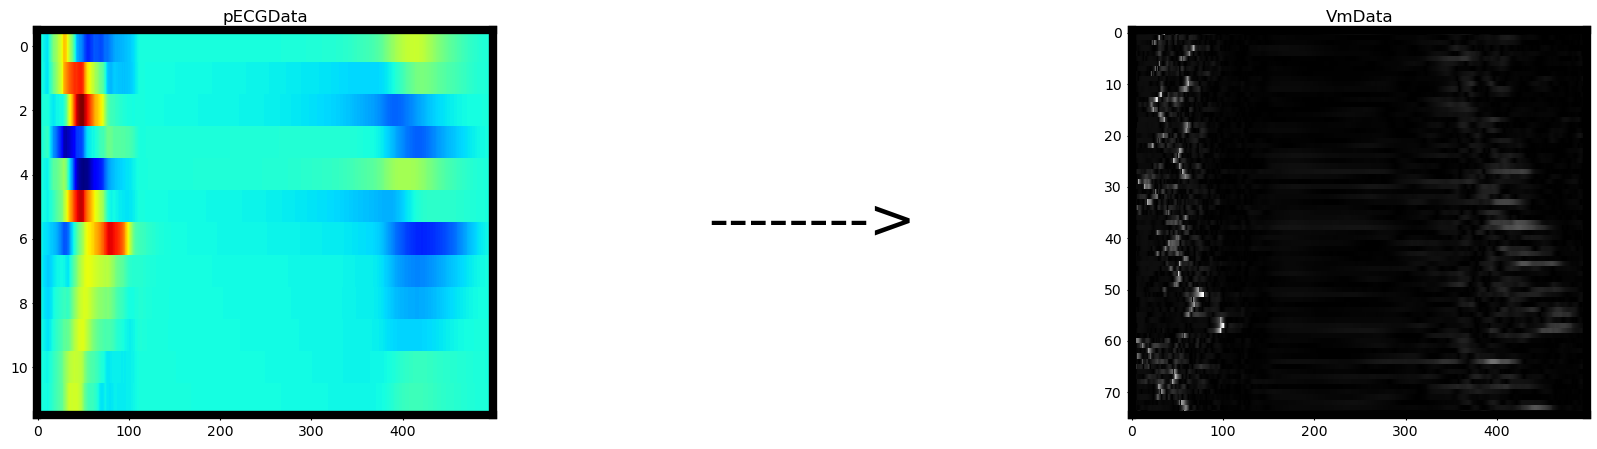

In [39]:
# make a plot with the "pECGData" -> "ActTime"
data_iter = iter(valid_dataloader)

data, label = next(data_iter)
output = model(data.float().to(device))
output = output*(max_value-min_value) + min_value
label = label*(max_value-min_value) + min_value

pECGData = data.squeeze().T
VmData1 = label.squeeze().cpu().detach().numpy().T
VmData2 = output.squeeze().cpu().detach().numpy().T
VmData = np.abs(VmData2-VmData1)

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 3
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print a text "->"
plt.text(0.5, 0.5, '-------->', fontsize=40, horizontalalignment='center', verticalalignment='center')
plt.axis('off')
plt.subplot(row, column, 3)
# plot Vm transposed
plt.imshow(VmData.T, cmap='gray', interpolation='nearest', aspect='auto')
plt.rcParams['axes.linewidth'] = 4

# not xticks
# plt.xticks([])
plt.title('VmData')
plt.show()
plt.close()

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(500, 75) (500, 75)


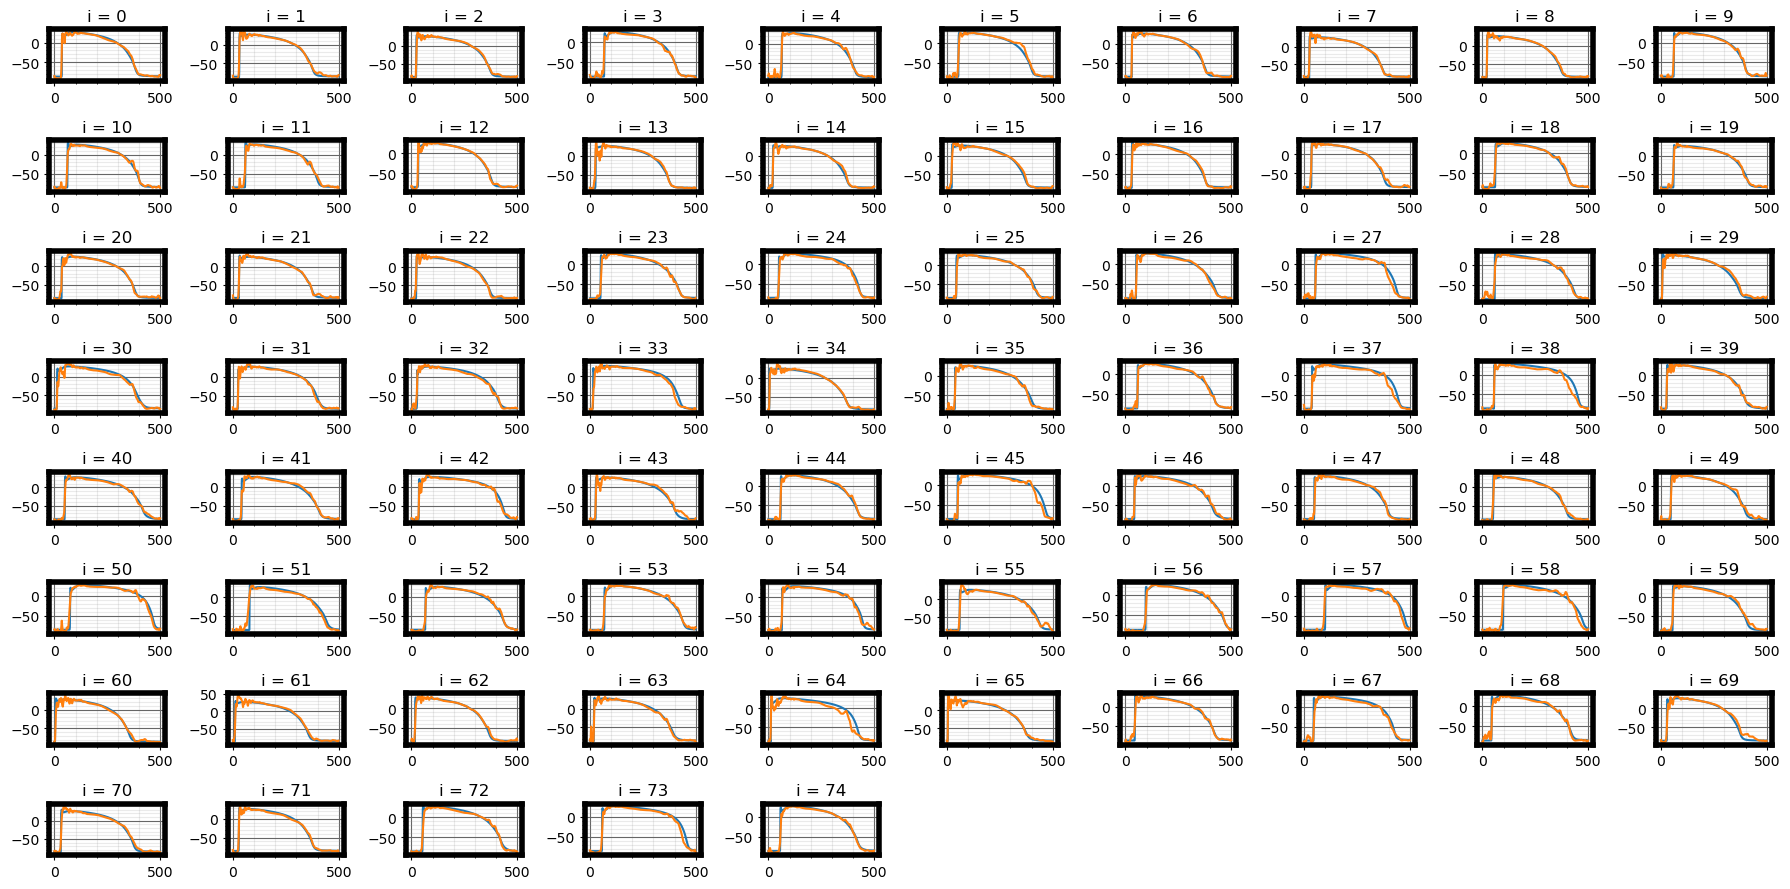

r2:  0.9811451521277111


In [40]:
# Example of file pair
# Vm plot
row = 7
column = 10
plt.figure(figsize=(18, 9))

print(type(VmData1), type(VmData2))
print(VmData1.shape, VmData2.shape)

for count, i in enumerate(range(VmData.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmData1[0:num_timesteps,i])
    plt.plot(VmData2[0:num_timesteps,i])
    plt.title(f'i = {i}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.rcParams['axes.linewidth'] = 2

plt.show()
# close
plt.close()
r2 = r2_score(VmData1, VmData2)
print("r2: ", r2)

C:\Users\Justin\AppData\Local\Temp\ipykernel_15156\1549833255.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('rainbow')


Case 213 : C:/Users/Justin/Documents/LLNL/Data/Task3/dataset/data_hearts_dd_0p2\pECGData_hearts_dd_0p2_volunteer.v1_pattern.18.npy
(500, 75)


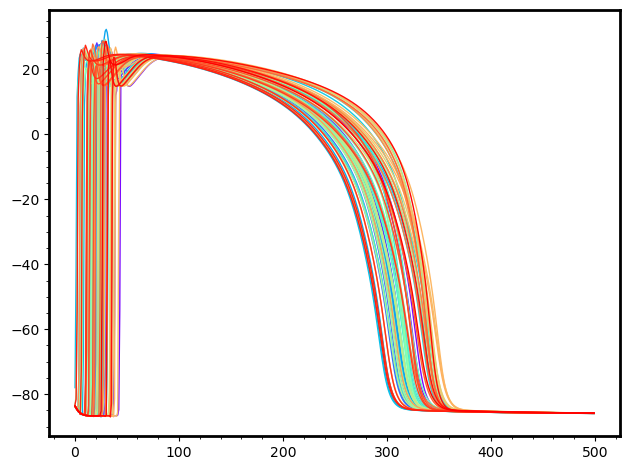

In [41]:
# Plot all actual line plots
# Example of file pair
case = 213

import matplotlib.pyplot as plt
import numpy as np

# Generate a range of 75 equally spaced values from 0 to 1
x = np.linspace(0, 1, 75)

# Create a colormap using the rainbow color map
colormap = plt.cm.get_cmap('rainbow')

# Map the range of values to colors from the colormap
colors = colormap(x)

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])
print(VmData.shape)

act_sort = np.sort(ActTime[case])

for count, i in enumerate(range(VmData.shape[1])):
    plt.plot(VmData[0:num_timesteps,i], linewidth = 1, color = colors[i])
    #plt.title(f'i = {i}')
    #plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    #plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.rcParams['axes.linewidth'] = 2
plt.tight_layout()
plt.show()
# close
plt.close()


# plot predicted heat map

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(500, 75) (500, 75)


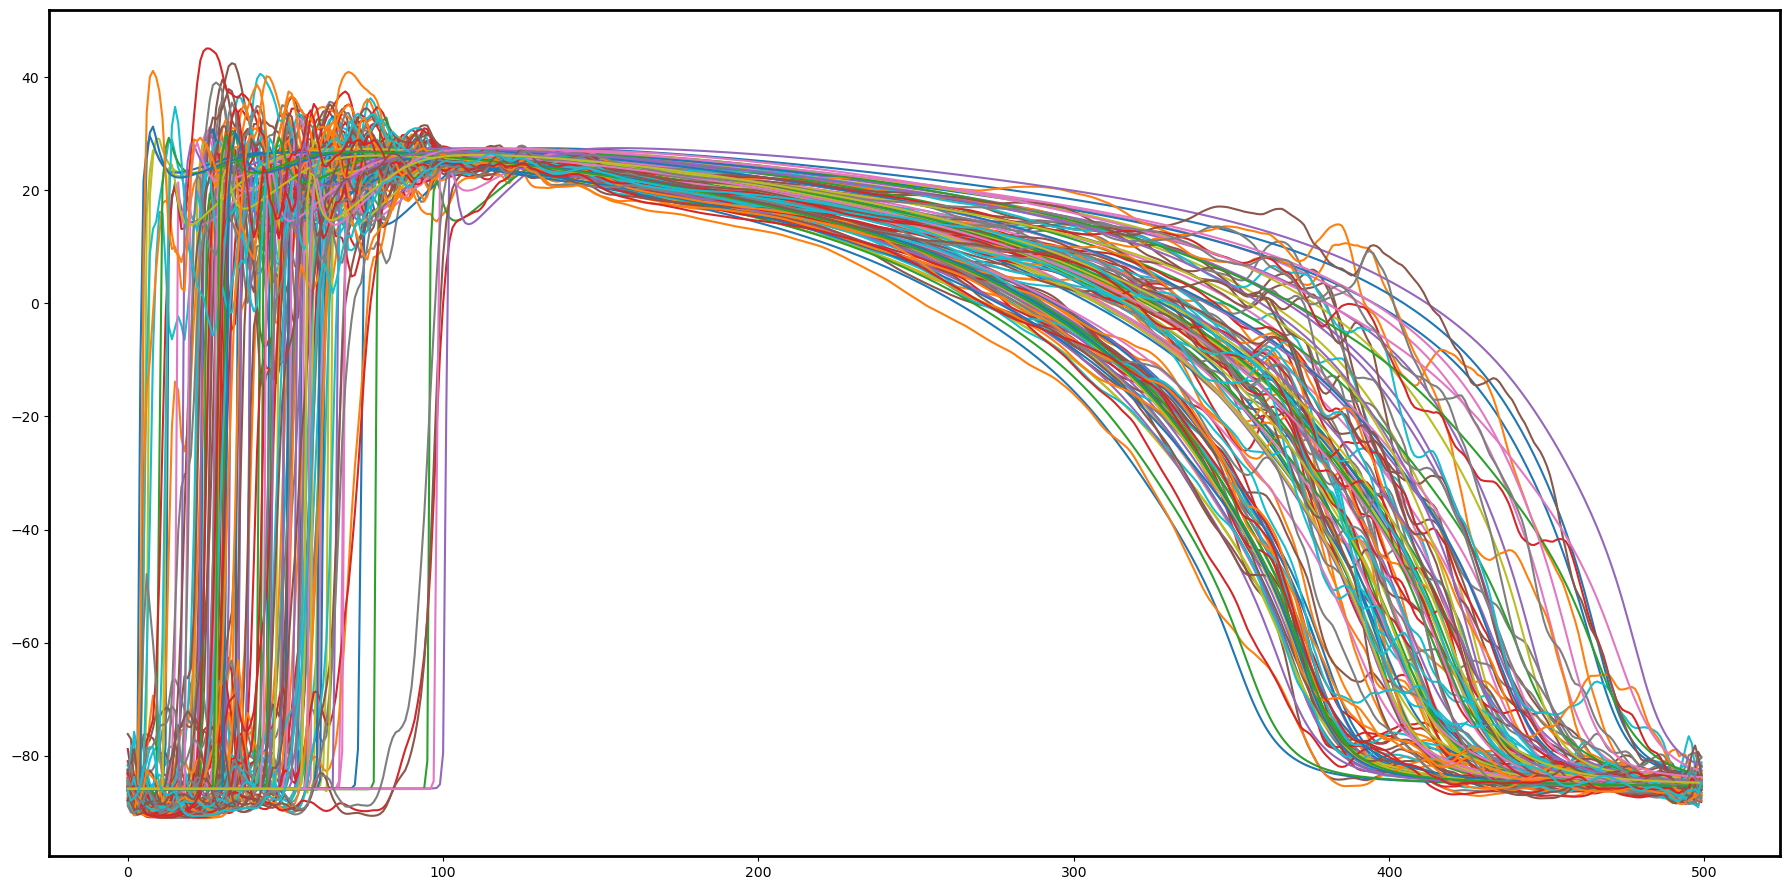

r2:  0.9811451521277111


In [42]:
# Plot all predicted line plots
# Example of file pair
# Vm plot
plt.figure(figsize=(18, 9))

print(type(VmData1), type(VmData2))
print(VmData1.shape, VmData2.shape)

for count, i in enumerate(range(VmData.shape[1])):
    plt.plot(VmData1[0:num_timesteps,i])
    plt.plot(VmData2[0:num_timesteps,i])
    #plt.title(f'i = {i}')
    #plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    #plt.minorticks_on()
    #plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()
r2 = r2_score(VmData1, VmData2)
print("r2: ", r2)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(500, 75) (500, 75)


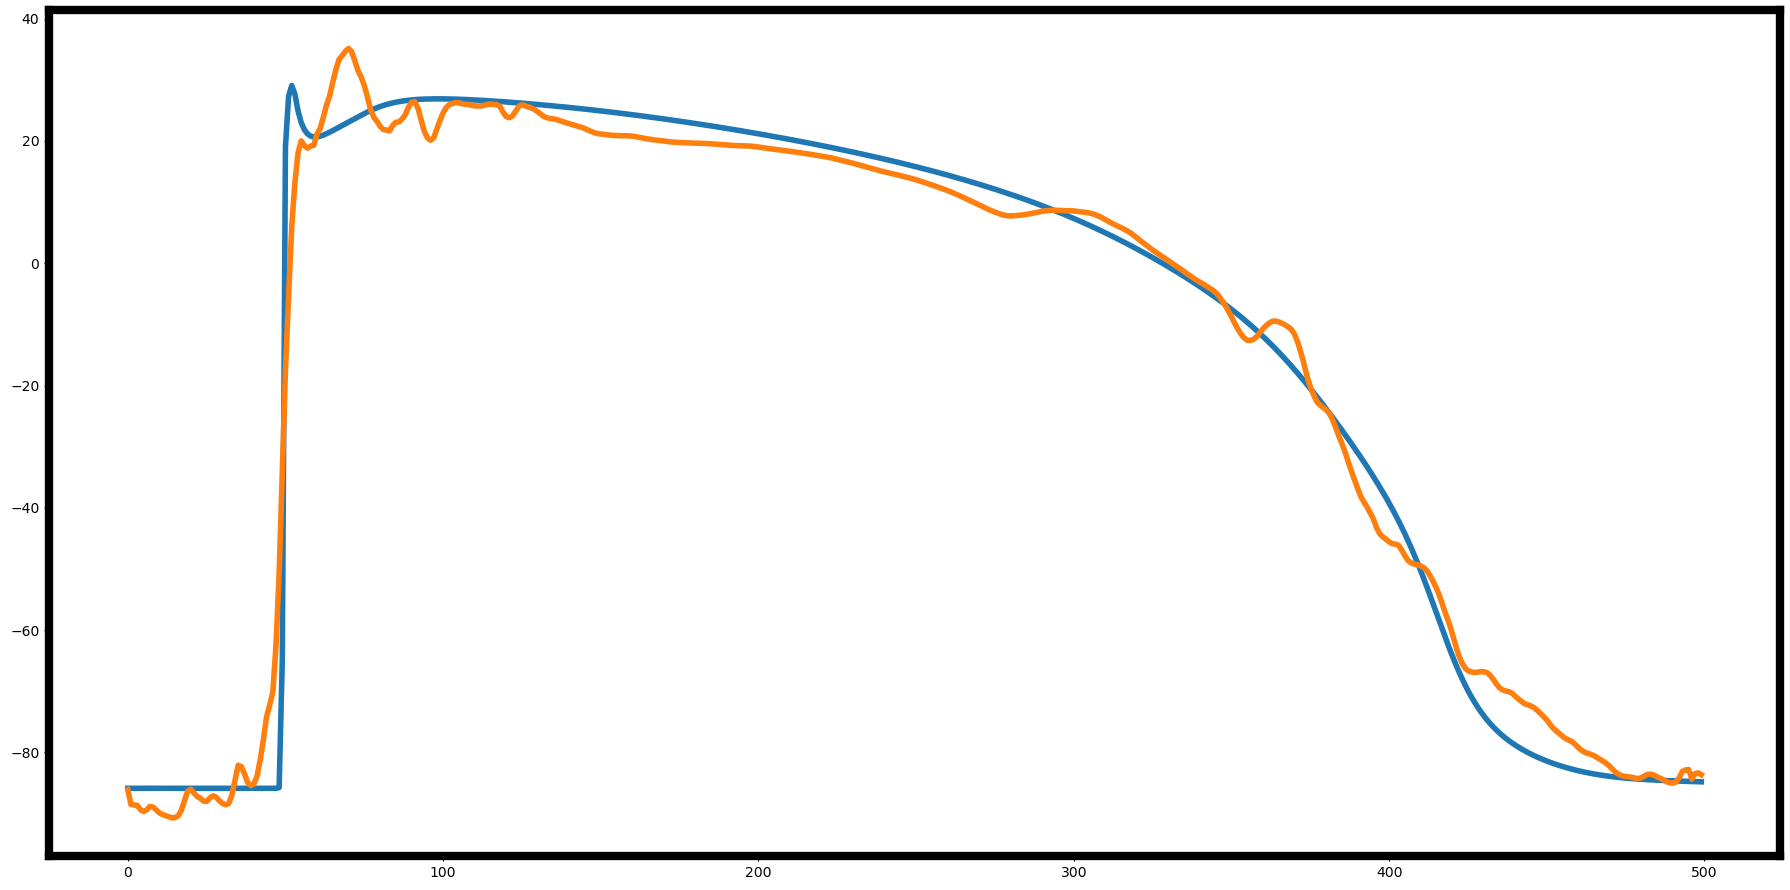

r2:  0.9811451521277111


In [35]:
# Plot all predicted line plots
# Example of file pair
# Vm plot
case = 40
plt.figure(figsize=(18, 9))

print(type(VmData1), type(VmData2))
print(VmData1.shape, VmData2.shape)

plt.plot(VmData1[0:num_timesteps,case],linewidth= 4)
plt.plot(VmData2[0:num_timesteps,case], linewidth= 4)
    #plt.title(f'i = {i}')
    #plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    #plt.minorticks_on()
    #plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()
r2 = r2_score(VmData1, VmData2)
print("r2: ", r2)

# Summary 

The dataset consisted of using only 5,000 patients out of 16,000, due to computing constraints, each with an ECG recording of 12 ECG leads and 500 timesteps (12x500x5,000). The primary question was whether a neural network could be constructed to take the 12x500 dataset to predict the activation curve of the 75x500 virtual heart location. We were able to predict the activation times of 75 virtual heart location over 500 ms using a 1D convolutional network. The 1D convolutional network took in a 12x500 data matrix and outputed a 75x500 matrix. In addition, we used a measure of variance captured, R^2, to measure the model fit of test vs predicted.